In [7]:
%reset

In [126]:
import sys
import time
import os
import copy
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn

from io import BytesIO
from time import sleep 
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected

from config import PATH_TO_FEATURES

PATH_TO_LINKING_DATA = '../../datasets/string/'
PATH_TO_SAVE_DATA_TO = '../../datasets/string/my_datasets/'

PROTEIN_LINKS_FILE = '9606.protein.links.detailed.v11.5.txt.gz'
PROTEIN_INFO_FILE = '9606.protein.info.v11.5.txt.gz'

sns.set_theme(style="white")

print(torch.__version__)
print(torch.cuda.is_available())

1.11.0
False


# Build a More Sparser Graph

The every single graph in the current set of graphs lying in `../../datasets/datasets_for_model_building/cl_graphs_as_dict.pkl` has the topology 
```python 
  Data(x=[858, 4], edge_index=[2, 83126])
```
which means it has 83,126 connection __per graph__. On average each node had 97 neighbors. This is way too much and has the reason that we took all the connection found in the protein-linking dataset, independent of their `combined_score` column value. In this notebook we will use the same approach as in `07_v1_get_linking_dataset.ipynb` but instead of using all found connection __we will only use connection which exceed a specified combined score threshold__.

_Objective_: The objective of this notebook is to bring the number of connection 83,126 significantly down. Therefore, bring the average of neighbors per node in the graph down (was 97 on average).

_Approach_: Use the `combined_score` column in the protein-interaction dataset.

_TODOs_: 
- [ ] incorporate the `combined_score` column
- [ ] decrease the number of connection to a number significantly smaller than 83,126
- [ ] decrease the average number of neighbors per node to a number significantly smaller then 97

### Helper Methods

In [20]:
def read_protein_links(path: str):
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_links_v1 = pd.read_csv(data, sep=' ')

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_links_v2 = protein_links_v1.copy()
    protein_links_v2.protein1 = protein_links_v2.protein1.str[5:]
    protein_links_v2.protein2 = protein_links_v2.protein2.str[5:]

    return protein_links_v2

def read_protein_info(path: str):
    contents = gzip.open(path, "rb").read()
    data = BytesIO(contents)
    protein_info_v1 = pd.read_csv(data, sep='\t')
    protein_info_v2 = protein_info_v1.rename(columns={'#string_protein_id': 'string_protein_id'}, inplace=False)

    # Exclude the Homo Sapiens taxonomy ID from the protein columns.
    protein_info_v2.string_protein_id = protein_info_v2.string_protein_id.str[5:]

    return protein_info_v2

def combine_protein_links_with_info(links: pd.DataFrame, infos: pd.DataFrame):
    """
    Maps the corresponding gene symbols to the proteins in the protein link dataset.

    Args:
        links (pd.DataFrame): DataFrame containing at least the columns `protein1` and `protein2`.
        infos (pd.DataFrame): DataFrame containing at least the columns `string_protein_id` and `preferred_name`.
    Returns:
        (pd.DataFrame): DataFrame containing the corresponding `gene_symbol` per `protein1` and `protein2`.
    """
    # Get the gene symbols for the protein1 column.
    res = links.merge(right    = infos[['string_protein_id', 'preferred_name']],
                      how      = 'left',
                      left_on  = 'protein1',
                      right_on = 'string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol1'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Get the gene symbols for the protein2 column.
    res = res.merge(right    = infos[['string_protein_id', 'preferred_name']],
                    how      = 'left',
                    left_on  = 'protein2',
                    right_on = 'string_protein_id')
    res.rename(columns={'preferred_name': 'gene_symbol2'}, inplace=True)
    res.drop(['string_protein_id'], axis=1, inplace=True)

    # Drop all rows where the gene symbol has not been found.
    res.dropna(subset=['gene_symbol1', 'gene_symbol2'], inplace=True)

    assert not res[['gene_symbol1', 'gene_symbol2']].isna().sum().any(),\
        "Some gene_symbol columns are missing!"

    return res    

## Load Protein Link Dataset

In [3]:
protein_links = read_protein_links(f'{PATH_TO_LINKING_DATA}{PROTEIN_LINKS_FILE}')
print(protein_links.shape)
protein_links.head(3)

(11938498, 10)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222


- there are 11,938,498 protein-protein connections in the given dataset
- each connection row contains a `combined_score` value

      coexpression textmining combined_score
count     11938498   11938498       11938498
mean            62        180            280
std             97        153            167
min              0          0            150
25%              0         67            175
50%             54        161            216
75%             76        241            309
max            999        997            999


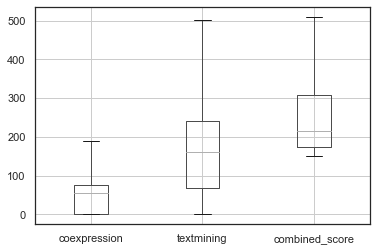

In [4]:
print(protein_links[['coexpression', 'textmining', 'combined_score']].describe().apply(lambda s: s.apply('{0:.0f}'.format)))
protein_links[['coexpression', 'textmining', 'combined_score']].boxplot(showfliers=False);

- the `combined_score` column seems to lie in $[150, 999]$

Let's get an overview of how many percentage of the dataset would be deleted when we chose specific thresholds for the `combined_score`.

In [5]:
threshs = np.arange(200, 951, 50)
before = protein_links.shape[0]
print(f"Out of {before} rows...")
for thresh in threshs:
    after = protein_links[protein_links.combined_score < thresh].shape[0]
    print(f"  for {thresh:3.0f} threshold {before-after:10.0f} would remain and {after:10.0f} ({100*after/before:05.2f}%) would get removed.")

Out of 11938498 rows...
  for 200 threshold    6969260 would remain and    4969238 (41.62%) would get removed.
  for 250 threshold    4628886 would remain and    7309612 (61.23%) would get removed.
  for 300 threshold    3193022 would remain and    8745476 (73.25%) would get removed.
  for 350 threshold    2329706 would remain and    9608792 (80.49%) would get removed.
  for 400 threshold    1795134 would remain and   10143364 (84.96%) would get removed.
  for 450 threshold    1427778 would remain and   10510720 (88.04%) would get removed.
  for 500 threshold    1149772 would remain and   10788726 (90.37%) would get removed.
  for 550 threshold     951666 would remain and   10986832 (92.03%) would get removed.
  for 600 threshold     809380 would remain and   11129118 (93.22%) would get removed.
  for 650 threshold     630798 would remain and   11307700 (94.72%) would get removed.
  for 700 threshold     505968 would remain and   11432530 (95.76%) would get removed.
  for 750 threshold

## Load Protein Info Dataset

In [6]:
protein_infos_v0 = read_protein_info(f'{PATH_TO_LINKING_DATA}{PROTEIN_INFO_FILE}')
print(protein_infos_v0.shape)
print(f"There are {len(protein_infos_v0.preferred_name.unique())} unique gene symbols in `preferred_name`.")
protein_infos_v0.head(3)

(19566, 4)
There are 19563 unique gene symbols in `preferred_name`.


,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


- this dataset gives us the gene symbol for each protein ID.
- some `preferred_name` (gene symbols) occur more then one time

In [7]:
freq_per_gene = protein_infos_v0.groupby(['preferred_name']).size().reset_index(name='freq', inplace=False).sort_values(['freq'], ascending=False)
freq_per_gene[freq_per_gene.freq>1]

,preferred_name,freq
5100,ENSG00000205457,2
5106,ENSG00000229117,2
5243,ENSG00000268221,2


We will remove the gene symbols which frequency higher then one

In [8]:
protein_infos = protein_infos_v0[~protein_infos_v0.preferred_name.isin(freq_per_gene[freq_per_gene.freq>1].preferred_name.tolist())]
print(protein_infos.shape)
protein_infos.head(3)

(19560, 4)


,string_protein_id,preferred_name,protein_size,annotation
0,ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


## Combine Protein Links and Info

In [21]:
proteins = combine_protein_links_with_info(protein_links, protein_infos)
print(proteins.shape)
proteins.head(3)

(11936122, 12)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
0,ENSP00000000233,ENSP00000379496,0,0,0,54,0,0,144,155,ARF5,PDE1C
1,ENSP00000000233,ENSP00000314067,0,0,0,0,180,0,61,197,ARF5,PAK2
2,ENSP00000000233,ENSP00000263116,0,0,0,62,152,0,101,222,ARF5,RAB36


In [22]:
print(f"""Shapes
    before joining : {protein_links.shape}
    after  joining : {proteins.shape}
There are 
    {len(proteins.gene_symbol1.unique())} unique genes (gene_symbol1) per column
    {len(proteins.gene_symbol2.unique())} unique genes (gene_symbol2) per column    
""")
# Unique number of gene-gene combinations.
freq_per_tuple = proteins\
    .groupby(['gene_symbol1', 'gene_symbol2']).size()\
    .reset_index(name='freq', inplace=False)\
    .sort_values(['freq'], ascending=False)
freq_per_tuple.groupby(['freq']).size().reset_index(name='count', inplace=False)

Shapes
    before joining : (11938498, 10)
    after  joining : (11936122, 12)
There are 
    19379 unique genes (gene_symbol1) per column
    19379 unique genes (gene_symbol2) per column    



,freq,count
0,1,11936122


In [154]:
THRESH = 0.95
proteins = proteins[proteins['combined_score'] > (THRESH * 1_000)]
print("Number of uniq gene_symbol1:", len(proteins.gene_symbol1.unique()))
print("Number of uniq gene_symbol2:", len(proteins.gene_symbol2.unique()))
proteins.shape

Number of uniq gene_symbol1: 9570
Number of uniq gene_symbol2: 9570


(110254, 12)

All gene-gene tuples occur exactly one time which is what we want. Now the protein-protein interaction dataset is preprocessed.

## Read Overlapping Genes and Cell-lines

The following intersecting cell-lines and genes got created in `07_v1_get_linking_dataset.ipynb`.

In [23]:
with open(f'{PATH_TO_FEATURES}intersecting_cls.pkl', 'rb') as f:
    INTER_CLS = list(pd.read_pickle(f))
with open(f'{PATH_TO_FEATURES}intersecting_genes.pkl', 'rb') as f:
    INTER_GENES = list(pd.read_pickle(f))
print("Number of intersecting cell-lines:", len(INTER_CLS))
print("Number of intersecting genes:", len(INTER_GENES))

Number of intersecting cell-lines: 983
Number of intersecting genes: 858


In [27]:
# Assign unique index to each of the genes.
INTER_GENES_IDXS = pd.DataFrame({'GENE_SYMBOL': list(INTER_GENES)})
INTER_GENES_IDXS['GENE_INDEX'] = INTER_GENES_IDXS.index
INTER_GENES_IDXS.head(5)

,GENE_SYMBOL,GENE_INDEX
0,PACSIN3,0
1,PIH1D1,1
2,CEBPD,2
3,SGCB,3
4,FCHO1,4


## Sparse Protein-Protein Interaction Dataset Using Intersecting Genes

Now we will use the set of intersecting genes to sparse down the protein-protein interaction dataset.

In [69]:
print(f"We have {len(proteins.gene_symbol1.unique())} unique genes in the protein-protein interaction dataset.")
print(f"We have {len(INTER_GENES_IDXS.GENE_SYMBOL.unique())} unique genes in the intersection dataset.")

We have 9570 unique genes in the protein-protein interaction dataset.
We have 858 unique genes in the intersection dataset.


In [155]:
# How many of the intersecting genes are also in the protein-protein interaction dataset?
print(len(list(set(proteins.gene_symbol1.unique()).intersection(set(INTER_GENES_IDXS.GENE_SYMBOL.unique())))))
print(len(list(set(proteins.gene_symbol2.unique()).intersection(set(INTER_GENES_IDXS.GENE_SYMBOL.unique())))))

679
679


In [160]:
t1 = proteins[proteins.gene_symbol1.isin(INTER_GENES_IDXS.GENE_SYMBOL)]
print(len(t1.gene_symbol1.unique()))
t2 = proteins[proteins.gene_symbol2.isin(INTER_GENES_IDXS.GENE_SYMBOL)]
print(len(t2.gene_symbol2.unique()))
t = proteins[(proteins.gene_symbol1.isin(INTER_GENES_IDXS.GENE_SYMBOL)) & (proteins.gene_symbol2.isin(INTER_GENES_IDXS.GENE_SYMBOL))]
print(len(t.gene_symbol1.unique()))
print(len(t.gene_symbol2.unique()))

679
679
458
458


All of the intersecting genes are also in the protein-protein interaction dataset.

In [74]:
proteins_v2 = proteins.loc[(proteins.gene_symbol1.isin(INTER_GENES_IDXS.GENE_SYMBOL)) &
                           (proteins.gene_symbol2.isin(INTER_GENES_IDXS.GENE_SYMBOL))]
n_rows = proteins_v2.shape[0]
perc_kept = 100*n_rows/proteins.shape[0]
print(f"""After filtered down such that both columns ´gene_symbol1´ and ´gene_symbol2´ are landmark genes the shape is {n_rows} ({perc_kept:2.2f} %). 
This means {proteins.shape[0]-proteins_v2.shape[0]} ({100*(proteins.shape[0]-proteins_v2.shape[0])/proteins.shape[0]:2.2f}%) have either one 
or both gene symbols not in the set of {INTER_GENES_IDXS.shape[0]} intersecting genes.""")
print("Number of unique gene_symbol1:", len(proteins_v2.gene_symbol1.unique()))
print("Number of unique gene_symbol2:", len(proteins_v2.gene_symbol2.unique()))
print("Shape before:", proteins.shape)
print("Shape now   :", proteins_v2.shape)
proteins_v2.head(3)

After filtered down such that both columns ´gene_symbol1´ and ´gene_symbol2´ are landmark genes the shape is 2380 (2.16 %). 
This means 107874 (97.84%) have either one 
or both gene symbols not in the set of 858 intersecting genes.
Number of unique gene_symbol1: 458
Number of unique gene_symbol2: 458
Shape before: (110254, 12)
Shape now   : (2380, 12)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2
2544,ENSP00000001008,ENSP00000302961,0,0,0,256,376,0,976,988,FKBP4,HSPA4
3364,ENSP00000001008,ENSP00000231509,0,0,0,0,848,900,980,999,FKBP4,NR3C1
13731,ENSP00000005257,ENSP00000361120,0,0,0,0,247,900,977,998,RALA,RALGDS


In [61]:
threshs = np.arange(0.5, 1.0, 0.05)
for THRESH in threshs:
    temp = proteins_v2[proteins_v2.combined_score > (THRESH * 1_000)]
    print(f"thresh: {round(THRESH*1_000)}, new shape: {temp.shape} ({100*temp.shape[0]/proteins_v2.shape[0]:2.2f}%).")
    len_inter = INTER_GENES_IDXS.shape[0]
    g1, g2 = len(temp.gene_symbol1.unique()), len(temp.gene_symbol2.unique())
    print(f"  uniq cols in `gene_symbol1`: {g1} ({100*g1/len_inter:2.2f}%); in `gene_symbol2`: {g2} ({100*g2/len_inter:2.2f}%) out of all {len_inter} intersecting genes.")

thresh: 500, new shape: (13732, 12) (16.52%).
  uniq cols in `gene_symbol1`: 793 (92.42%); in `gene_symbol2`: 793 (92.42%) out of all 858 intersecting genes.
thresh: 550, new shape: (11898, 12) (14.31%).
  uniq cols in `gene_symbol1`: 773 (90.09%); in `gene_symbol2`: 773 (90.09%) out of all 858 intersecting genes.
thresh: 600, new shape: (10436, 12) (12.55%).
  uniq cols in `gene_symbol1`: 751 (87.53%); in `gene_symbol2`: 751 (87.53%) out of all 858 intersecting genes.
thresh: 650, new shape: (8986, 12) (10.81%).
  uniq cols in `gene_symbol1`: 721 (84.03%); in `gene_symbol2`: 721 (84.03%) out of all 858 intersecting genes.
thresh: 700, new shape: (7794, 12) (9.38%).
  uniq cols in `gene_symbol1`: 696 (81.12%); in `gene_symbol2`: 696 (81.12%) out of all 858 intersecting genes.
thresh: 750, new shape: (6828, 12) (8.21%).
  uniq cols in `gene_symbol1`: 672 (78.32%); in `gene_symbol2`: 672 (78.32%) out of all 858 intersecting genes.
thresh: 800, new shape: (6080, 12) (7.31%).
  uniq cols i

In [75]:
# Append corresponding index for each gene symbol column as new column(s).
proteins_v3 = proteins_v2.merge(
    right=INTER_GENES_IDXS,
    how='left',
    left_on=['gene_symbol1'],
    right_on=['GENE_SYMBOL'])
proteins_v3.rename(columns={'GENE_INDEX': 'index_gene_symbol1'}, inplace=True)
proteins_v3.drop(['GENE_SYMBOL'], axis=1, inplace=True)

proteins_v4 = proteins_v3.merge(
    right=INTER_GENES_IDXS,
    how='left',
    left_on=['gene_symbol2'],
    right_on=['GENE_SYMBOL'])
proteins_v4.rename(columns={'GENE_INDEX': 'index_gene_symbol2'}, inplace=True)
proteins_v4.drop(['GENE_SYMBOL'], axis=1, inplace=True)

print(f"Shape: {proteins_v4.shape}")
proteins_v4.head(3)

Shape: (2380, 14)


,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene_symbol1,gene_symbol2,index_gene_symbol1,index_gene_symbol2
0,ENSP00000001008,ENSP00000302961,0,0,0,256,376,0,976,988,FKBP4,HSPA4,163,414
1,ENSP00000001008,ENSP00000231509,0,0,0,0,848,900,980,999,FKBP4,NR3C1,163,93
2,ENSP00000005257,ENSP00000361120,0,0,0,0,247,900,977,998,RALA,RALGDS,811,795


In [101]:
proteins_v5 = proteins_v4[['protein1', 'protein2', 'gene_symbol1', 'gene_symbol2', 'index_gene_symbol1', 'index_gene_symbol2', 'combined_score']]
NODES_AS_SYMBOLS = np.unique(proteins_v5[['gene_symbol1', 'gene_symbol2']].values)
NODES_AS_INDECES = np.unique(proteins_v5[['index_gene_symbol1', 'index_gene_symbol2']].values)
print(f"There will be {len(NODES_AS_SYMBOLS)} nodes in the graph.")
print(f"There will be {len(NODES_AS_INDECES)} indices in the graph.")
print(proteins_v5.shape)
proteins_v5.head(3)

There will be 458 nodes in the graph.
There will be 458 indices in the graph.
(2380, 7)


,protein1,protein2,gene_symbol1,gene_symbol2,index_gene_symbol1,index_gene_symbol2,combined_score
0,ENSP00000001008,ENSP00000302961,FKBP4,HSPA4,163,414,988
1,ENSP00000001008,ENSP00000231509,FKBP4,NR3C1,163,93,999
2,ENSP00000005257,ENSP00000361120,RALA,RALGDS,811,795,998


In [98]:
# Create a list of tuples which hold neighbor nodes.
gene_symbol_tuples = list(set(list(zip(proteins_v5.gene_symbol1, proteins_v5.gene_symbol2))))
print(gene_symbol_tuples[:5])

# Map the list of tuples of neighbor gene nodes to the corresponding int. 
transform_gene_tuple_to_index_tuple = lambda x : (
    INTER_GENES_IDXS[INTER_GENES_IDXS['GENE_SYMBOL']==x[0]]['GENE_INDEX'].values[0], 
    INTER_GENES_IDXS[INTER_GENES_IDXS['GENE_SYMBOL']==x[1]]['GENE_INDEX'].values[0])
input_vec = [transform_gene_tuple_to_index_tuple(tup) for tup in gene_symbol_tuples]
print(input_vec[:5])

neighbor_gene_tuples = copy.deepcopy(input_vec)
print("Number of neighbor tuples:", len(neighbor_gene_tuples))

[('SOCS2', 'GHR'), ('POLR2K', 'GTF2E2'), ('PXN', 'PTK2'), ('FYN', 'CDC42'), ('ILK', 'IQGAP1')]
[(613, 196), (178, 557), (450, 320), (819, 846), (488, 304)]
Number of neighbor tuples: 2380


## Create Undirected Neighbor Tuples

In [100]:
# Saving all tuples the other way around.
a_to_b = [[tup[0], tup[1]] for tup in neighbor_gene_tuples]
b_to_a = [[tup[1], tup[0]] for tup in neighbor_gene_tuples]

NEIGHBOR_GENES_UNDIRECTED = a_to_b + b_to_a
assert len(NEIGHBOR_GENES_UNDIRECTED) == 2*len(neighbor_gene_tuples), \
    "The undirected list of gene tuples needs to be exactly two times the directed one!"

for tup in NEIGHBOR_GENES_UNDIRECTED:
    assert [tup[1], tup[0]] in NEIGHBOR_GENES_UNDIRECTED, f"{tup} not undirected!"

print(len(NEIGHBOR_GENES_UNDIRECTED))
print(NEIGHBOR_GENES_UNDIRECTED[:5])

4760
[[613, 196], [178, 557], [450, 320], [819, 846], [488, 304]]


## Dictionary of Neighbors Per Gene

### Using `GENE_INDEX`

In [105]:
# Find neighbors using the indices.
dict_as_indices = {gene_node: [] for gene_node in NODES_AS_INDECES}  # or dict(zip(nodes, []*len(nodes)))

# Get the edges.
for gene in dict_as_indices:
    exists_in_gene_symbol1 = not proteins_v5.loc[proteins_v5.index_gene_symbol1==gene].empty
    exists_in_gene_symbol2 = not proteins_v5.loc[proteins_v5.index_gene_symbol2==gene].empty

    neighbor_nodes = None 
    if exists_in_gene_symbol1:
        neighbor_nodes = list(set(proteins_v5.loc[proteins_v5.index_gene_symbol1==gene].index_gene_symbol2))
    elif exists_in_gene_symbol2: 
        neighbor_nodes = list(set(proteins_v5.loc[proteins_v5.index_gene_symbol2==gene].index_gene_symbol1))
    else: 
        print(f"The gene {gene} couldn't be found in the dataset!") 

    # Set neighbors for the gene.
    dict_as_indices[gene] += [neighbor_node for neighbor_node in neighbor_nodes if neighbor_node not in dict_as_indices[gene]]

__Format__: 
- _key_: unique index of the gene symbol
- _value_: list of  gene symbol indices which are neighbors of the gene symbol index of the key

On average there are     5 neighbors per node.
Note that there are 458 keys/nodes/genes in total.
Thus, on average 1.13 % of all genes are neighbors.


,nr_neighbors
count,458.000000
mean,5.196507
std,7.032328
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,63.000000


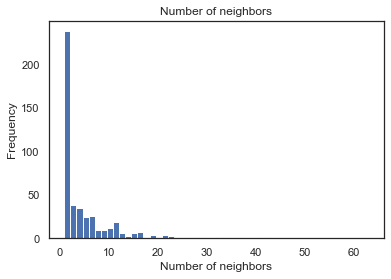

In [111]:
# How many neighbors are there on average?
len_of_neighbors = [len(neighbors) for _, neighbors in dict_as_indices.items()]
assert len(len_of_neighbors) == len(NODES_AS_INDECES)
print(f"On average there are {np.mean(len_of_neighbors):5.0f} neighbors per node.")
print(f"Note that there are {len(dict_as_indices.keys())} keys/nodes/genes in total.")
print(f"Thus, on average {100*np.mean(len_of_neighbors)/len(dict_as_indices.keys()):2.2f} %" +
    " of all genes are neighbors.")
plt.hist(len_of_neighbors, bins=50);
plt.title("Number of neighbors");
plt.xlabel("Number of neighbors");
plt.ylabel("Frequency");
pd.DataFrame(len_of_neighbors, columns=['nr_neighbors']).describe()

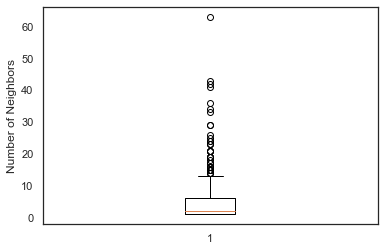

In [114]:
plt.boxplot(len_of_neighbors);
plt.ylabel('Number of Neighbors');

---

### Loading the Node Feature Datasets

In [121]:
# -------------------------------------- #
# Read cell-line - gene feature datasets #
# -------------------------------------- #
READ = True

if READ:
    start = time.time()
    with open(f'{PATH_TO_FEATURES}gexpr_sparse.pkl', 'rb') as f: 
        gexpr = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}cnvg_sparse.pkl', 'rb') as f: 
        cnvg = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}cnvp_sparse.pkl', 'rb') as f: 
        cnvp = pickle.load(f)
    with open(f'{PATH_TO_FEATURES}mut_sparse.pkl', 'rb') as f: 
        mut = pickle.load(f)  
    print(f"Took {time.time()-start:.5f} seconds to read the cell-line feature datasets.")
    print(f"""Shapes
    Gene Expression : {gexpr.shape}
    CNV Gistic      : {cnvg.shape}
    CNV Picnic      : {cnvp.shape}
    Mutation        : {mut.shape}
    """)

Took 0.01642 seconds to read the cell-line feature datasets.
Shapes
    Gene Expression : (983, 859)
    CNV Gistic      : (983, 859)
    CNV Picnic      : (983, 859)
    Mutation        : (983, 859)
    


In [122]:
def get_uniqs(df: pd.DataFrame, col: str):
    return np.unique(df[col].values).tolist()

# Test that all feature datasets contains exactly the same cell-lines.
gexpr_cls = get_uniqs(gexpr, 'CELL_LINE_NAME')
cnvg_cls = get_uniqs(cnvg, 'CELL_LINE_NAME')
cnvp_cls = get_uniqs(cnvp, 'CELL_LINE_NAME')
mut_cls = get_uniqs(mut, 'CELL_LINE_NAME')
inter_cls = set(gexpr_cls) \
    .intersection(set(cnvp_cls)) \
    .intersection(set(cnvp_cls)) \
    .intersection(set(mut_cls))

assert len(inter_cls) == len(gexpr_cls) == len(cnvg_cls) == len(cnvp_cls) == len(mut_cls), \
    "Not all feature datasets contain the exact same cell-lines as rows!"

# Test that all feature datasets contains exactly the same gene symbols.
inter_genes = set(np.unique(gexpr.columns.values).tolist()) \
    .intersection(set(np.unique(cnvg.columns.values).tolist())) \
    .intersection(set(np.unique(cnvp.columns.values).tolist())) \
    .intersection(set(np.unique(mut.columns.values).tolist()))

assert len(inter_genes) == \
    len(np.unique(gexpr.columns.values).tolist()) == \
    len(np.unique(cnvg.columns.values).tolist()) == \
    len(np.unique(cnvp.columns.values).tolist()) == \
    len(np.unique(mut.columns.values).tolist()), \
        "Not all feature datasets contain the exact same gene symbols as columns!"

del gexpr_cls, cnvg_cls, cnvp_cls, mut_cls, inter_cls, inter_genes

In [123]:
gexpr.set_index('CELL_LINE_NAME', inplace=True)
cnvg.set_index('CELL_LINE_NAME', inplace=True)
cnvp.set_index('CELL_LINE_NAME', inplace=True)
mut.set_index('CELL_LINE_NAME', inplace=True)

In [118]:
gexpr.head(3)

,CELL_LINE_NAME,FBXL12,PIN1,PAK4,GNA15,ARPP19,EAPP,MOK,MTHFD2,TIPARP,...,PDHX,DFFB,FOSL1,ETS1,EBNA1BP2,MYL9,MLLT11,PFKL,FGFR4,SDHB
0,22RV1,7.023759,6.067534,4.318750,3.261427,6.297582,8.313991,5.514912,10.594112,5.222366,...,7.821536,3.601622,3.225596,3.651201,7.895763,3.953414,4.059382,4.376822,3.215209,9.267565
1,23132-87,6.714387,5.695096,4.536146,3.295886,7.021037,8.500080,4.862145,10.609245,6.528668,...,8.094289,3.596762,3.486299,3.127452,7.852436,3.869411,4.248318,4.989945,4.328643,9.515870
2,42-MG-BA,7.752402,5.475753,4.033714,3.176525,7.279671,8.013367,4.957332,11.266705,7.445954,...,7.984052,3.317746,5.106906,5.305024,6.508066,7.840349,8.632889,4.792137,3.078971,8.495921


## Build PyTorch-Geometric Formatted Graph

Note that since the topology of each graph per cell-line will be identical, only the feature values are changing.

```python
    Data(
        x           # changing for each cell-line.
        edge_index  # doesn't change for each cell-line.
    )
```

In [145]:
print(len(GENES))

858


In [146]:
len(NEIGHBOR_GENES_UNDIRECTED)

4760

In [150]:
GENES = list(NODES_AS_SYMBOLS) # list(INTER_GENES)
Gs = {}
for cl in tqdm(list(INTER_CLS)):
    # Convert the feature values to tensors and stack them up.
    gexpr_cl = torch.tensor(gexpr.loc[cl][GENES].values, dtype=torch.float64)
    cnvg_cl = torch.tensor(cnvg.loc[cl][GENES].values, dtype=torch.float64)
    cnvp_cl = torch.tensor(cnvp.loc[cl][GENES].values, dtype=torch.float64)
    mut_cl = torch.tensor(mut.loc[cl][GENES].values, dtype=torch.float64)

    features = torch.stack([gexpr_cl, cnvg_cl, cnvp_cl, mut_cl]).t()

    # Generate the graph.
    edge_index = torch.tensor(NEIGHBOR_GENES_UNDIRECTED, dtype=torch.long).t().contiguous()
    # G_cl = Data(x=features, edge_index=to_undirected(edge_index)) --> gives Data(x=[858, 4], edge_index=[2, 2380])
    G_cl = Data(x=features, edge_index=edge_index)

    Gs[cl] = G_cl

100%|██████████| 983/983 [00:08<00:00, 112.59it/s]


In [153]:
with open(f'{PATH_TO_FEATURES}cl_graphs_as_dict_SPARSE.pkl', 'wb') as f:
    pickle.dump(Gs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [152]:
print(Gs['22RV1'])
print(Gs['22RV1'].x)

Data(x=[458, 4], edge_index=[2, 4760])
tensor([[ 5.2021, -1.0000,  2.0000,  1.0000],
        [ 6.3496,  0.0000,  2.0000,  0.0000],
        [ 9.8674,  0.0000,  2.0000,  0.0000],
        ...,
        [ 6.1017,  0.0000,  2.0000,  0.0000],
        [ 6.5084,  1.0000,  3.0000,  1.0000],
        [ 7.0576,  0.0000,  2.0000,  0.0000]], dtype=torch.float64)


In [135]:
len(NEIGHBOR_GENES_UNDIRECTED)

4760

In [144]:
len(NODES_AS_SYMBOLS)

458